In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
import ipynb.fs.full.utils as utils
import ipynb.fs.full.features as features
import ipynb.fs.full.features_distancias as f_distancias


df_train = pd.read_csv('./data/train_filtrado.csv')
# Para usarse con el submit a Kaggle
df_eval = pd.read_csv('./data/test.csv')

df_train, df_eval = features.features_de_csvs(df_train, df_eval)

df_train_idf = pd.read_csv('./data/train_idf.csv')
df_eval_idf = pd.read_csv('./data/test_idf.csv')

df_train = pd.merge(df_train, df_train_idf, on= 'id', how= 'left')
df_eval = pd.merge(df_eval, df_eval_idf, on= 'id', how= 'left')

# Randoms solo para asegurarse que los features esten bien hechos
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_train = utils.dolarizar_df(df_train)
# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_train, df_test = utils.dividir_df_testeo(df_train, test_size=0.4)

df_test = features.llenar_nulls(df_test, hgb_mean=True, df_fill=df_train)
df_train = features.llenar_nulls(df_train, hgb_mean=True)


# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_test = utils.pesificar_df(df_test)
# df_train = df_train.sample(frac=1).reset_index(drop=True)


In [2]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', df_aux=df_test_f)


df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

# df_train_f = df_train_f.sample(frac=1).reset_index(drop=True)

df_train_f = f_distancias.feature_distancias(df_train_f)
df_test_f = f_distancias.feature_distancias(df_test_f, df_train_f)


In [8]:
df_corr = df_train_f[['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad', 'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos','metroscubiertos','metrostotales', 'idzona','lat', 'lng', 'fecha','gimnasio', 'usosmultiples','piscina','escuelascercanas', 'centroscomercialescercanos', 'similares_count', 'idf_titulo', 'idf_descripcion', 'peso_titulo', 'peso_descripcion','metrostotales_log', 'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros', 'intervalo_metros_totales', 'intervalo_metros_cubiertos', 'metroscubiertos_bins_unif', 'metroscubiertos_bins_perc', 'metros_totales_normalizados', 'metros_cubiertos_normalizados', 'escomercial', 'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad', 'tipo_propiedad_compartida', 'prop_frecuente', 'zona', 'top_provincia', 'es_ciudad_centrica', 'promedio_metros_totales_provincia', 'promedio_metros_cubiertos_provincia','anio', 'mes', 'dia', 'trimestre', 'dias_desde_datos', 'meses_desde_datos','escualas_centros_cercanos','delincuencia', 'turismo', 'es_antigua', 'antiguedad_bins_unif', 'antiguedad_bins_perc', 'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia', 'promedio_provincia_log', 'promedio_precio_ciudad', 'promedio_ciudad_log', 'promedio_precio_ciudad_gen', 'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona', 'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad', 'promedio_precio_tipo_propiedad_ciudad', 'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes', 'promedio_precio_habitaciones', 'promedio_precio_habitaciones_banos_garages', 'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad', 'promedio_precio_hbg_tipo_propiedad_provincia', 'promedio_precio_hbg_tipo_propiedad_provincia_gen', 'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje', 'tipodepropiedad_Apartamento', 'tipodepropiedad_Bodega comercial', 'tipodepropiedad_Casa', 'tipodepropiedad_Casa en condominio', 'tipodepropiedad_Casa uso de suelo', 'tipodepropiedad_Departamento Compartido', 'tipodepropiedad_Duplex', 'tipodepropiedad_Edificio', 'tipodepropiedad_Inmuebles productivos urbanos','tipodepropiedad_Local Comercial', 'tipodepropiedad_Local en centro comercial', 'tipodepropiedad_Oficina comercial', 'tipodepropiedad_Otros', 'tipodepropiedad_Quinta Vacacional', 'tipodepropiedad_Rancho', 'tipodepropiedad_Terreno', 'tipodepropiedad_Terreno comercial', 'tipodepropiedad_Villa', 'tipodepropiedad_otro', 'provincia_Aguascalientes', 'provincia_Baja California Norte','provincia_Baja California Sur', 'provincia_Campeche', 'provincia_Chiapas', 'provincia_Chihuahua', 'provincia_Coahuila', 'provincia_Colima', 'provincia_Distrito Federal', 'provincia_Durango', 'provincia_Edo. de México', 'provincia_Guanajuato', 'provincia_Guerrero', 'provincia_Hidalgo', 'provincia_Jalisco', 'provincia_Michoacán', 'provincia_Morelos', 'provincia_Nayarit', 'provincia_Nuevo León', 'provincia_Oaxaca', 'provincia_Puebla', 'provincia_Querétaro','provincia_Quintana Roo', 'provincia_San luis Potosí', 'provincia_Sinaloa', 'provincia_Sonora', 'provincia_Tabasco', 'provincia_Tamaulipas', 'provincia_Tlaxcala', 'provincia_Veracruz', 'provincia_Yucatán','provincia_otro', 'zona_Centro', 'zona_Norte ','zona_Sur', 'distancia_ciudad_centrica', 'distancia_centro_mexico','distancia_ciudad_cara', 'precio']]

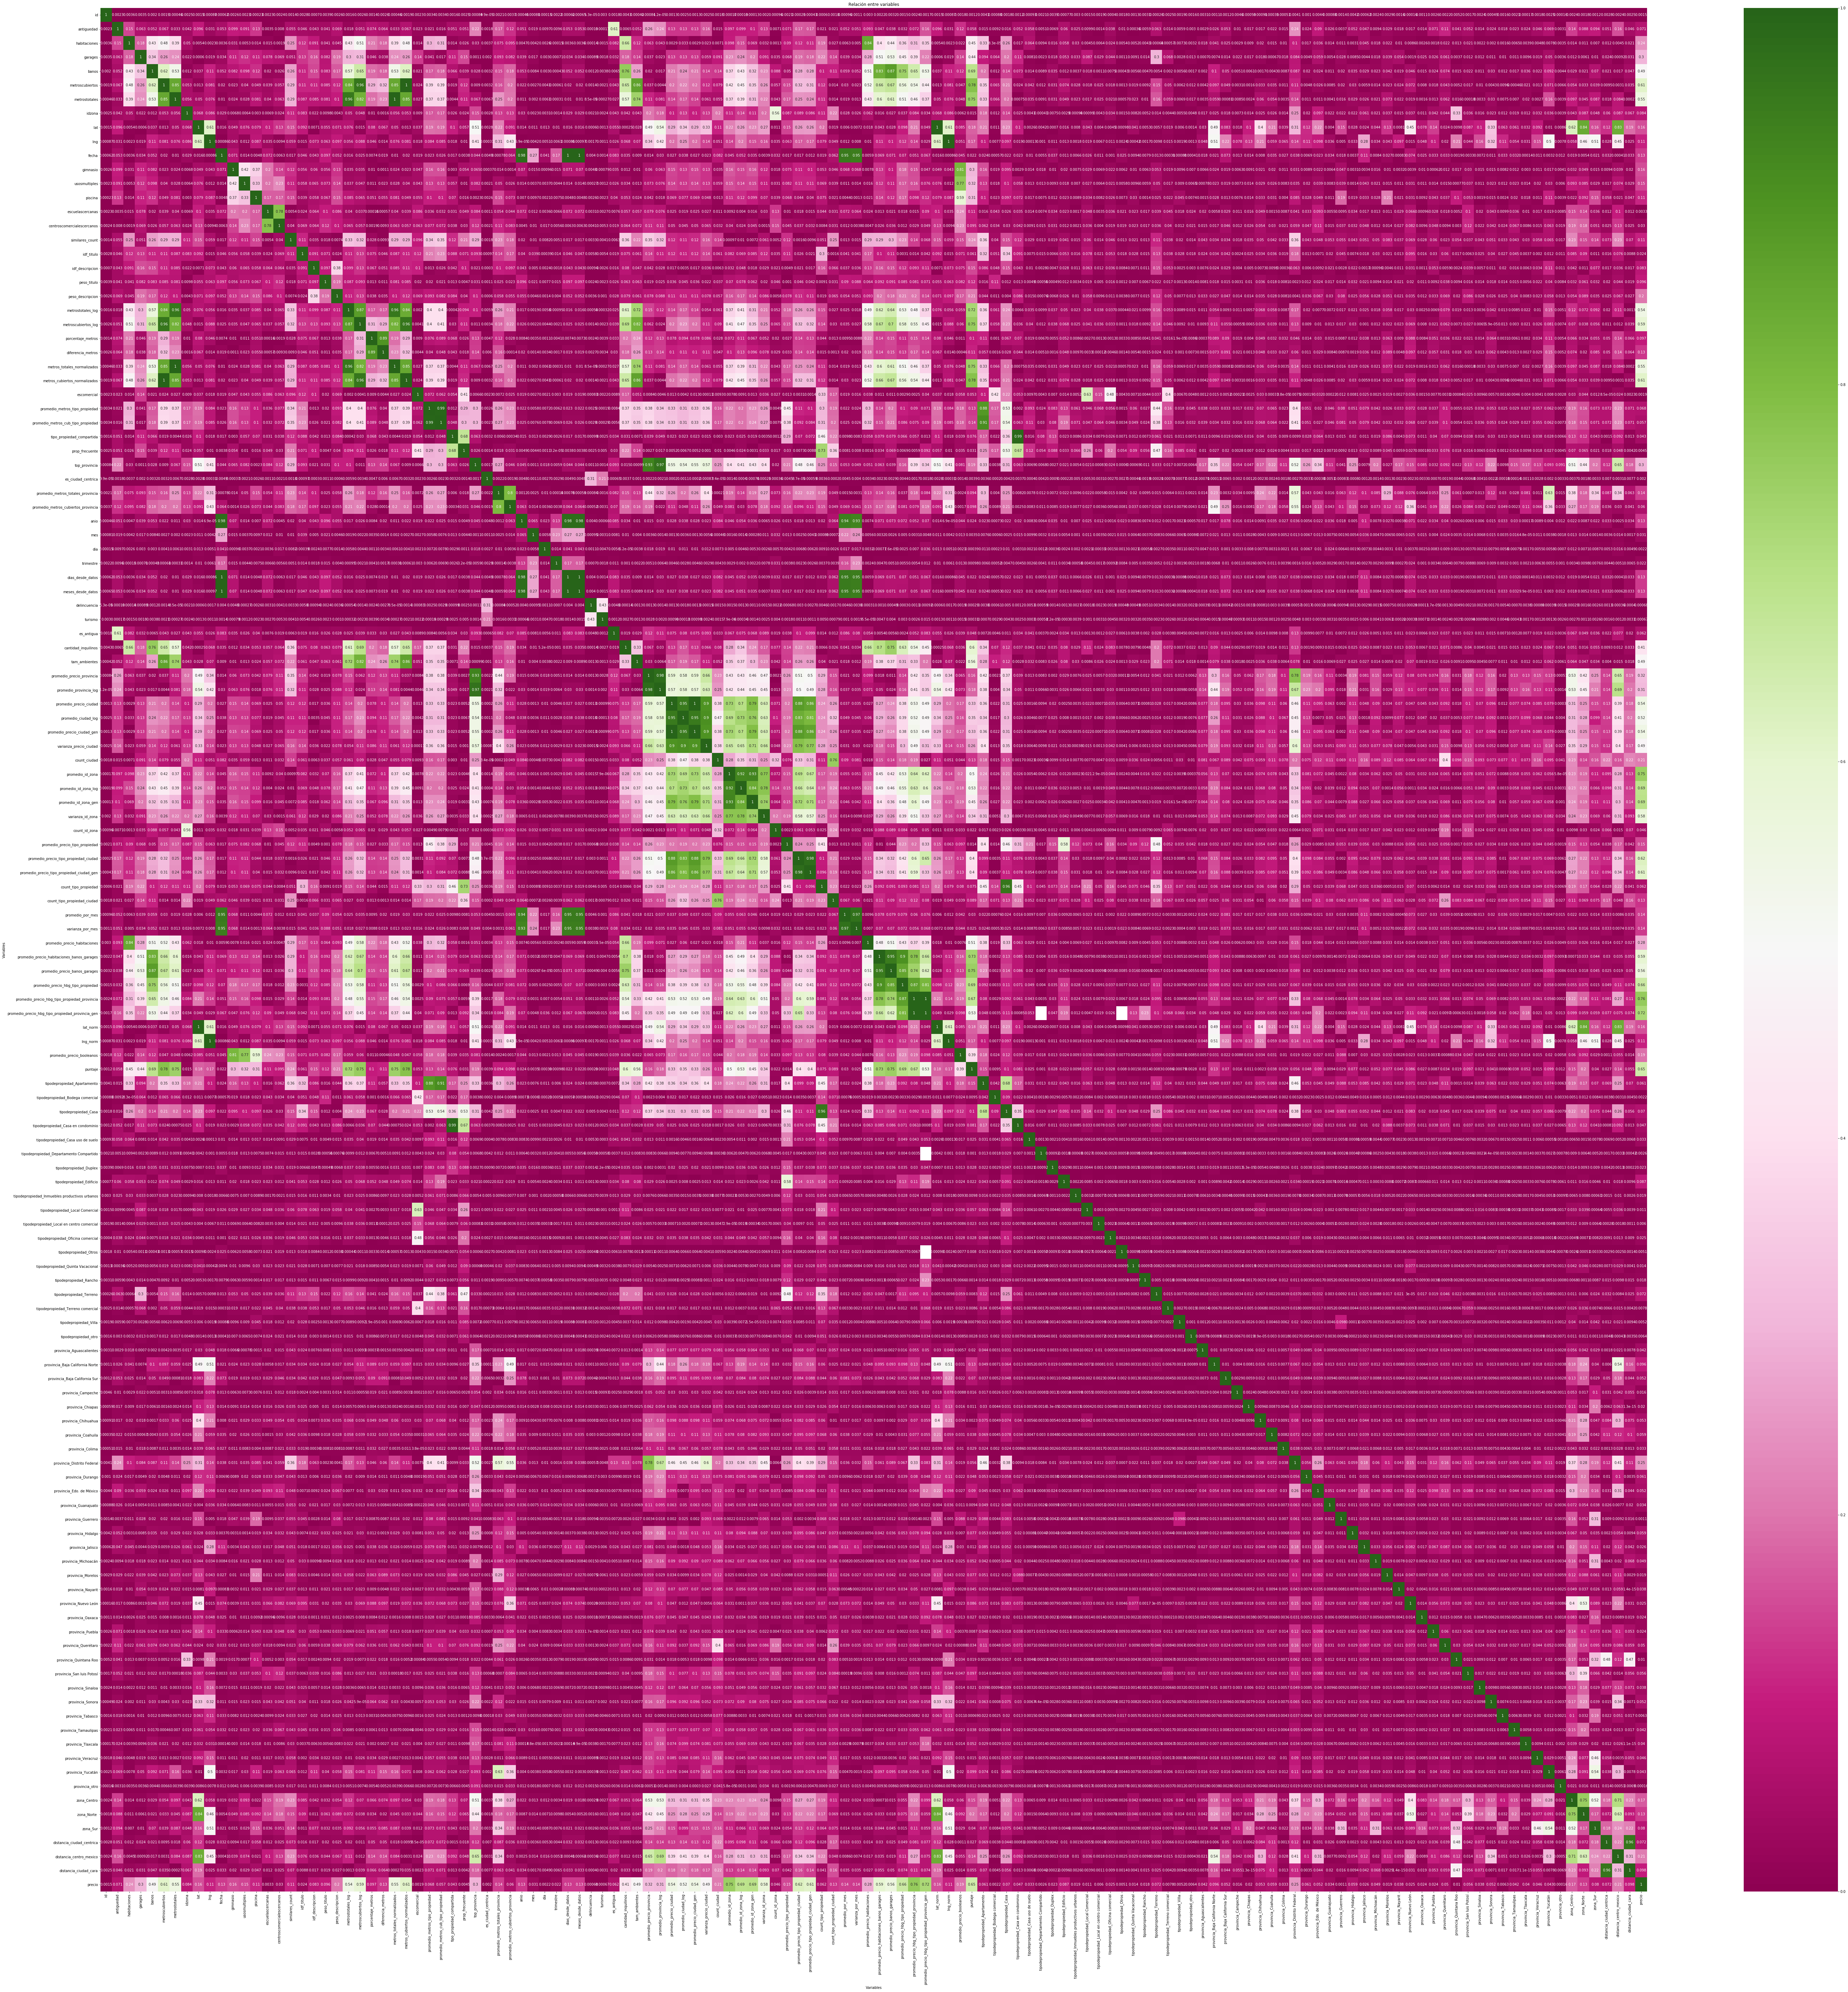

In [9]:
import matplotlib.pylab as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(100,100))
cor = df_corr.corr().abs()

sns.heatmap(cor,cmap='PiYG',  annot= True);
ax.axes.set_title("Relación entre variables")
ax.set_xlabel("Variables")
ax.set_ylabel("Variables")
ax.tick_params(labelsize=10)
